In this notebook, we will estimate the fixed points corresponding to EWA learning dynamics in the Gamma > 0 (potential-like game) setting.  Recall the fixed points of the effective dynamics $x(z)$ obey the following equation as found via the path integral method.

\begin{equation}
0=  \left[\Gamma  x(z) \chi - \frac{1}{r} \ln x(z) + \sqrt{q}z - \rho \right]x(z)
\end{equation}

where:

$z \sim \mathcal{N} (0,1)$

For $\Gamma > 0$,
$ \left[\Gamma  x(z) \chi - \frac{1}{r} \ln x(z) + \sqrt{q}z - \rho \right] = 0 $ does not have a solution for all $z$.  Thus, we have to set $x(z) = 0 $ for some $z$.

## The most Interior fixed point

We propose the following Ansatz for $x(z)$ in this regime.

$\begin{align}
x(z)= 
\begin{cases}
Ke^{bz+ax(z)} \; \; &, z < z_{crit} \\
0 \; \; &, z \geq z_{crit}
\end{cases}
\end{align}$

where:
$\begin{align}
a&= \Gamma \chi r \\
b&= \sqrt{q} r > 0 \\
z_{crit} &= -\frac{1}{b} \left( 1 + \ln(\alpha K)\right) \\
\end{align}$

The parameters, $(K, a , b)$ ,must obey the following 'self-sufficiency' conditions: 

$\begin{align} 
q &= \int^{z_{crit}}_{-\infty} x^2(z) Dz \notag \\ 
1 &= \int^{z_{crit}}_{-\infty} x(z) Dz\notag  \\
\chi &= \int^{z_{crit}}_{-\infty} \frac{d x(z)}{dz} Dz\notag  \\
\end{align}$

where:

$Dz$ is pdf corresponding to the standard normal.

This Ansatz represents the 'most-interior' fixed points of our dynamics.  Further fixed points of $x(z)$  could be found by reducing $z_{crit}$, thereby increasing the regime where $x(z) = 0$

In [8]:
#Import Packages

import numpy as np
from scipy.integrate import quad
import scipy.stats as stats
from scipy import optimize
from scipy.optimize import minimize
from scipy.special import lambertw

import warnings


### Define functions x(z), dx/dz and Dz

In [3]:
def return_x(K, a , b):

    '''Input: 
    Parameters K, a , b'''
    '''Output: 
    functions- x(z), dx(z)/dz
    crit_values- z_crit, x(z_crit)'''

    def x(z):
        return np.real(-(1/a) * lambertw( -K * a * np.exp(b*z) , tol=1e-12))
    
    def deriv_x(z):
        xz= x(z)

        return b*xz/  (1- a* xz)
    
    x_crit = 1/a
    
    crit_z = -(1+ np.log(a* K)) / b
    
    return x, deriv_x, crit_z , x_crit

def Dz(z):
    '''Pdf of standard normal'''
    return np.exp(-z**2/2) / np.sqrt(2*np.pi)

### Define loss functions and stability condition

The stability condition takes this form:

$$
\begin{align}
 \int \bigg|\frac{ 1}{r x^\star} - \Gamma  \chi\bigg|^{-2} Dz < \phi ^{-1}
\end{align}
$$

where:

$\phi$ is the propotion of non-extinct strategies.  We have included a function to check the stability condition below

In [4]:
def custom_loss(r, gamma):

    def loss(x0):

        '''Deviation from self-sufficiency condition is treated as a loss function to minimise'''
        '''Do gradient descent -> 0 to find optimal parameters'''

        K,a,b =x0

        x, deriv_x, crit_z , x_crit= return_x(K,a ,b)

        integrand_1  = lambda z : x(z) * Dz(z)
        integrand_2  = lambda z : x(z)**2 * Dz(z)
        integrand_3  = lambda z : deriv_x(z)* Dz(z)

        '''Scipy quad integration with a bazillion cuts for numerical accuracy'''
        cuts= 5000000
        eps= 1e-9

        loss_1 = 1 - quad(integrand_1, -np.inf, crit_z- eps, epsabs=1.49e-12, epsrel=1.49e-12, limit=cuts)[0]
        loss_2 = (b/r)**2 - quad(integrand_2, -np.inf, crit_z- eps, epsabs=1.49e-12, epsrel=1.49e-12, limit=cuts)[0]
        loss_3 = (a/(gamma*r)) - ( quad(integrand_3, -np.inf, crit_z- eps, epsabs=1.49e-12, epsrel=1.49e-12, limit=cuts)[0] - x_crit * Dz(crit_z))

        '''Loss = square deviation from self-sufficency equations'''
        losses= loss_1**2 +  loss_2**2 + loss_3**2

        return losses
    
    def stability_check(x0):

        '''Checks the stability given a choice of x(z)'''

        '''Output = +ve   =>  Unstable'''
        '''Output = -ve   =>  Stable'''
        '''Output = 0   =>  Boundary of Stability'''

        K,a,b = x0

        x, deriv_x, crit_z , x_crit= return_x(K,a ,b)

        stability_integrand = lambda z: Dz(z) * ( x(z)/ (1-a*x(z)) )**2

        cuts= 5000000
        eps= 2e-8

        stability_integral= quad(stability_integrand, -np.inf, crit_z- eps, epsabs=1.49e-15, epsrel=1.49e-15, limit=cuts )[0] + stability_integrand(crit_z -0.5*eps) * eps
        phi =   stats.norm.cdf(crit_z)
      
        #phi*r**2 *stability_integral - 1
        return phi*r**2 *stability_integral - 1 
    
    return loss, stability_check

def stability_r(gamma,x0 ,r0):

  '''Find Stability Boundary given Gamma, r  and initial guess x0 (K0, a0, b0) (only works if initial guess is close enough)'''
    
  def root_function(r):

    loss_f, stab_check= custom_loss(r, gamma)
    res= minimize(loss_f, x0, bounds = [(1e-7, None), (1e-8, None), (1e-8, None)], method='Nelder-Mead', tol=1e-8)

    return stab_check(res.x)
  
  sol= optimize.root(root_function, r0, tol=1e-8, method='lm', options = {'maxstep': 0.01})

  return sol

### Demo on a selected r and $\Gamma$

In [13]:
#Initialise initial guess

K0, a0, b0 = 0.7592959,  0.03574393, 0.65948725
r , gamma = 0.51, 0.1
initial_guess= [K0, a0 ,b0]

#Create loss functions corresponding to r and Gamma
loss_f, stab_check= custom_loss(r= r, gamma= gamma)

#Disable Integration warning.  Often our integration has a 'pole' but the integration converges. The magnitude of the estimated loss gives us a rough idea, though it is likely an underestimate.
warnings.filterwarnings('ignore', category=UserWarning)

#Conduct gradient-descent to identify optimum parameter values
res= minimize(loss_f, initial_guess, bounds = [(1e-7, None), (1e-8, None), (1e-8, None)], method='Nelder-Mead', tol=1e-8)

#Display loss (deviation from self-sufficiency eq)
print(f'loss: {res.fun}')
#Display parameters K,a,b.
print(f'parameters: {res.x}')
#Check stability 
print(f'stab_check: {stab_check(res.x)}')

loss: 1.0482091106657335e-17
parameters: [0.7592959  0.03574393 0.65948725]
stab_check: -0.007248844662147924


In [14]:
#Reenable warnings
warnings.filterwarnings('default', category=UserWarning)

Below is the stability curve corresponding to the Ansatz above. This had been done through searching tuning the initial conditions for each r and $\Gamma$ by hand. 

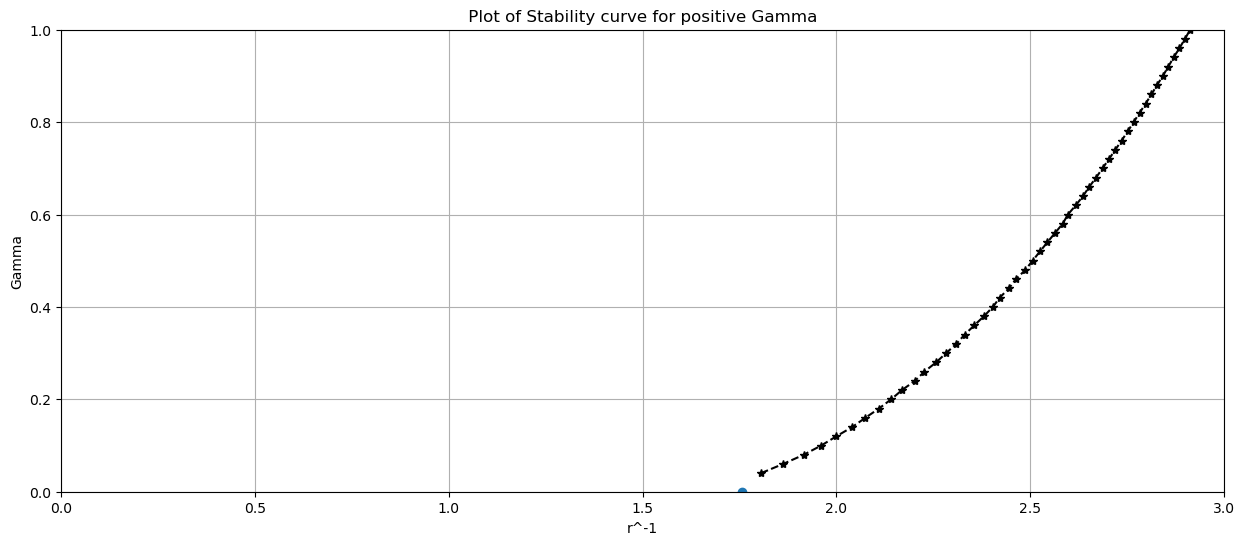

In [15]:
import matplotlib.pyplot as plt

r_arr= np.array([0.554,0.537,0.522,0.510,
        0.500, 0.490, 0.482, 0.474, 0.467,
        0.461, 0.454, 0.449, 0.443, 0.438,
        0.433, 0.429, 0.4245, 0.4200, 0.416,
        0.413, 0.409, 0.406, 0.402, 0.399,
        0.396, 0.393, 0.390, 0.387, 0.385,
        0.382, 0.3793, 0.377, 0.3745, 0.3722,
        0.3699, 0.3677, 0.3655, 0.3634, 0.3614,
        0.3594, 0.3574, 0.3555, 0.3537, 0.3518,
        0.3501, 0.3484, 0.3466, 0.3449, 0.3433])
gamma_arr= np.linspace(0.04, 1, 49)


f, ax = plt.subplots(figsize=(15, 6))

plt.plot(1/r_arr, gamma_arr, color='black', marker='*', linestyle='dashed')

plt.plot([1/0.569], [0],'o' )
plt.grid()

ax.set_xlim((0,3)); 
ax.set_ylim((0,1));  

plt.title(" Plot of Stability curve for positive Gamma ")
plt.ylabel("Gamma")
plt.xlabel("r^-1");